Reads the file `query_with_refinements.csv`

Generate the images, save them to `image_query/`

Overwrites the file `query.csv` (a backup of the past file is saved to `query_backup.csv`)

In [1]:
import pandas as pd
import sys
import os
import shutil
import zipfile
import logging
from PIL import Image
from typing import List
import matplotlib.pyplot as plt
import openai
from openai.error import RateLimitError
import base64
import io
import dotenv
import time
import shutil
from typing import Optional
import logging
from huggingface_hub import HfApi, snapshot_download
import torch
from diffusers.utils import load_image
from transformers import AutoModelForCausalLM

dataset = 'urban-reid-challenge-augmented'
#dataset = 'urban-reid-challenge-reduced'
#dataset = 'urban-reid-challenge'

################ Probably nothing has to be modified from now on ################
logging.root.setLevel(logging.INFO)
dotenv.load_dotenv()

os.environ['CUDA_VISIBLE_DEVICES']='0'
sys.path.append('assets/libs/diffusion-self-distillation')
assert os.path.exists('assets/libs/diffusion-self-distillation/')

from transformer import FluxTransformer2DConditionalModel
from pipeline import FluxConditionalPipeline

In [4]:
!pwd

/home/benle1/Urban-Elements-ReID-Challenge/Code/Files for PAT


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [2]:
class IdentityDiffuserDSD():
    def __init__(
        self,
        model_path: str,                   # Path to the 'transformer' folder
        lora_path: str,                    # Path to the 'pytorch_lora_weights.safetensors' file
        guidance: float = 3.5,             # Guidance scale
        i_guidance: float = 1.0,           # True image guidance scale, set to >1.0 if you want to enhance the image conditioning
        t_guidance: float = 1.0,           # True text guidance scale, set to >1.0 if you want to enhance the text conditioning
        model_offload: bool = False,       # Enable basic model offloading to CPU to reduce GPU memory usage (recommended, requires ~23.7GB VRAM)
        sequential_offload: bool = False,  # Enable more aggressive sequential offloading (saves more memory but much slower, requires < 1GB VRAM)
        steps: int = 28,
    ):
        transformer = FluxTransformer2DConditionalModel.from_pretrained(
            model_path,
            torch_dtype=torch.bfloat16,
            ignore_mismatched_sizes=True,
        )
        pipe = FluxConditionalPipeline.from_pretrained(
            "black-forest-labs/FLUX.1-dev",
            transformer=transformer,
            torch_dtype=torch.bfloat16,
        )
        assert isinstance(pipe, FluxConditionalPipeline)
        pipe.load_lora_weights(lora_path)
        if model_offload:
            pipe.enable_model_cpu_offload()
        if sequential_offload:
            pipe.enable_sequential_cpu_offload()
        if not model_offload and not sequential_offload:
            pipe.to("cuda")

        self.guidance = guidance
        self.i_guidance = i_guidance
        self.t_guidance = t_guidance
        self.steps = steps
        self.pipe = pipe

    # Open the image
    def predict(
        self,
        image_path: str,
        output_path: str,
        text: str,
    ):
        image = Image.open(image_path).convert("RGB")

        print(f"Process image: {image_path}")

        # Process image and text
        result_image = self.process_image_and_text(
            self.pipe,
            image,
            text,
            self.guidance,
            self.i_guidance,
            self.t_guidance,
            self.steps
        )

        # Save the output
        result_image.save(output_path)
        print(f"Output saved to {output_path}")

    def process_image_and_text(
        self,
        pipe,
        image,
        text,
        guidance,
        i_guidance,
        t_guidance,
        steps,
    ):
        """Process the given image and text using the global pipeline."""
        # center-crop image
        w, h = image.size
        min_size = min(w, h)
        image = image.crop(
            (
                (w - min_size) // 2,
                (h - min_size) // 2,
                (w + min_size) // 2,
                (h + min_size) // 2,
            )
        )
        image = image.resize((512, 512))

        control_image = load_image(image)
        result = pipe(
            prompt=text.strip().replace("\n", "").replace("\r", ""),
            negative_prompt="",
            num_inference_steps=steps,
            height=512,
            width=1024,
            guidance_scale=guidance,
            image=control_image,
            guidance_scale_real_i=i_guidance,
            guidance_scale_real_t=t_guidance,
        ).images[0]

        return result





def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                abs_path = os.path.join(root, file)
                rel_path = os.path.relpath(abs_path, folder_path)
                zipf.write(abs_path, arcname=rel_path)


def generate(split: str, has_label: bool, generate: bool = True):
    df = pd.read_csv(f'assets/datasets/{dataset}/{split}_with_refinements.csv')
    assert df.shape[1] == (5 if has_label else 4)

    # TODO: warning "Some weights of the model checkpoint were not used when initializing FluxTransformer2DConditionalModel"
    # Is that ok?
    model = IdentityDiffuserDSD(
        model_path="assets/models/dsd_pretrained/transformer",
        lora_path="assets/models/dsd_pretrained/pytorch_lora_weights.safetensors",
        guidance=3.5,
        i_guidance=1.0,
        t_guidance=1.0,
        sequential_offload=True,  # TODO: define this automatically based on available memory
    )

    t0 = time.time()
    i: int = 0
    df_refinement = df[df['imageName'].str.contains('_refinement_')]
    logging.info(f'Generating {df_refinement.shape[0]} images')
    for index, row in df_refinement.iterrows():
        output_path = os.path.join(f'assets/datasets/{dataset}/image_{split}', row['imageName'])

        if generate:
            model.predict(
                image_path=output_path.replace('_refinement', '').replace('_A.', '.').replace('_B.', '.').replace('_C.', '.'),
                output_path=output_path,
                text=row['description'],
            )

            plt.imshow(plt.imread(output_path))
            plt.title(row['imageName'])
            plt.show()
        i += 1
        if i%50 == 0:
            logging.info(f'Generated {i} images in {(time.time() - t0)} s')

    #Overwrites the file `query.csv`
    shutil.copy2(
        src=f'assets/datasets/{dataset}/{split}.csv',
        dst=f'assets/datasets/{dataset}/{split}_backup.csv',
    )
    df.drop(['class', 'description'], axis=1).to_csv(f'assets/datasets/{dataset}/{split}.csv', index=False)

    # zip_folder(f'assets/datasets/{dataset}/image_{split}/', f'assets/image_{split}.zip')
    logging.info(df.head(10))
    return df

INFO:root:--------------------------------------------------
Genenerating train
Some weights of the model checkpoint at assets/models/dsd_pretrained/transformer were not used when initializing FluxTransformer2DConditionalModel: 
 ['single_transformer_blocks.18.attn.to_q.lora_A.default.weight, single_transformer_blocks.33.attn.to_v.lora_A.default.weight, transformer_blocks.4.attn.to_v.lora_A.default.weight, single_transformer_blocks.17.attn.to_v.lora_B.default.weight, single_transformer_blocks.9.attn.to_q.lora_A.default.weight, single_transformer_blocks.14.attn.to_k.lora_B.default.weight, transformer_blocks.15.attn.add_q_proj.lora_B.default.weight, transformer_blocks.17.attn.add_q_proj.lora_B.default.weight, transformer_blocks.11.attn.to_q.lora_A.default.weight, transformer_blocks.17.attn.to_add_out.lora_B.default.weight, single_transformer_blocks.3.attn.to_q.lora_B.default.weight, single_transformer_blocks.34.attn.to_v.lora_B.default.weight, single_transformer_blocks.30.attn.to_k.lora_

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to T5EncoderModel found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any T5EncoderModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
INFO:root:Generating 5 images


Process image: assets/datasets/urban-reid-challenge-augmented/image_train/000001.jpg


  0%|          | 0/28 [00:00<?, ?it/s]

Output saved to assets/datasets/urban-reid-challenge-augmented/image_train/000001_refinement_A.jpg


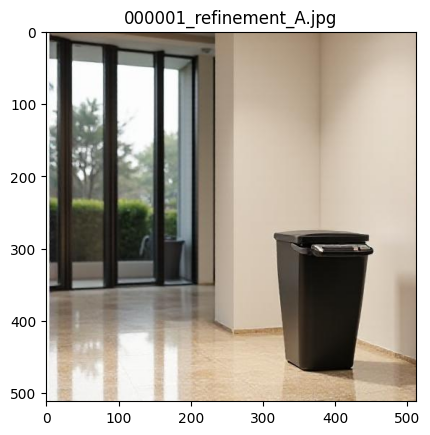

Process image: assets/datasets/urban-reid-challenge-augmented/image_train/000002.jpg


  0%|          | 0/28 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
# On a100, it takes about 500s to generate 50 images

for split, has_label in [
    #('query', False),
    #('test', False),
    ('train', True),
]:
    logging.info('-'*50 + f'\nGenenerating {split}')
    generate(split, has_label)
logging.info('All done, go celebrate')